In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### 1: Data extraction
Extract RhoA median levels across cell lines for KO and DLC1 cells from pickle file (Lucien Hinderling).

In [5]:
# Import dataset and visualise relevant columns
data_dir = os.path.join("../Data")
path_to_df = os.path.join(data_dir, "max_focal_adhesions.pkl")
df = pd.read_pickle(path_to_df)
df.columns

Index(['label', 'x', 'y', 'pax', 'rhoa', 'label_cell_mean', 'dist', 'pax_max',
       'rhoa_max', 'label_cell', 'dist_max', 'exp', 'frame', 'cell_type',
       'type', 'fov', 'pax_cell', 'rhoa_cell', 'roi_id', 'rhoa_norm',
       'rhoa_ratio_norm', 'pax_norm', 'pax_ratio_norm'],
      dtype='object')

In [20]:
# Extract the median RhoA activity across all frames for WT and KO cells at membrane and FA
median_NONFA_KO_rhoa_per_frame = df[((df['type']=='NON-FA') & 
                                     (df['cell_type']=='KO') & 
                                     (df['dist'] > dist))].groupby('frame')['rhoa_ratio_norm'].median()
median_NONFA_rhoa_per_frame = df[((df['type']=='NON-FA') & 
                                  (df['cell_type']=='WT') & 
                                  (df['dist'] > dist))].groupby('frame')['rhoa_ratio_norm'].median()
median_FA_KO_rhoa_per_frame = df[((df['type']=='FA') & 
                                  (df['cell_type']=='KO') & 
                                  (df['dist'] > dist))].groupby('frame')['rhoa_ratio_norm'].median()
median_FA_rhoa_per_frame = df[((df['type']=='FA') & 
                               (df['cell_type']=='WT') &
                               (df['dist']>dist))].groupby('frame')['rhoa_ratio_norm'].median()

<Axes: xlabel='frame'>

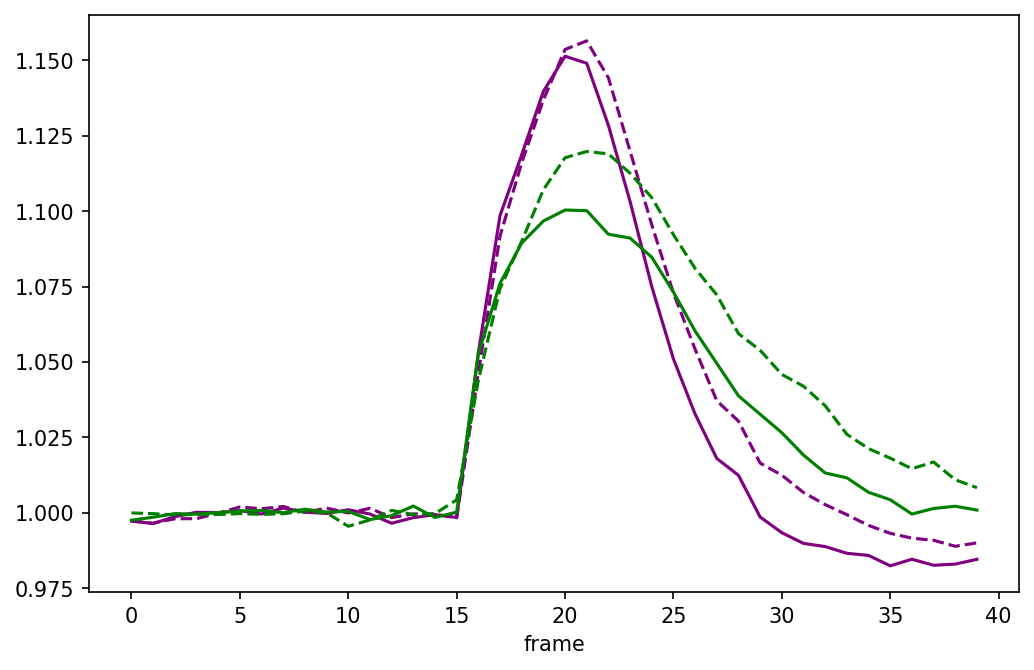

In [21]:
plt.figure(dpi = 150, figsize = (8,5))
dist = 0

median_NONFA_KO_rhoa_per_frame.plot(c = 'purple')
median_FA_KO_rhoa_per_frame.plot(c = 'purple',linestyle = 'dashed')

median_NONFA_rhoa_per_frame.plot(c = 'green')
median_FA_rhoa_per_frame.plot(c = 'green',linestyle = 'dashed')

In [ ]:
# Export to npy files to import with numpy (all variables in one file)
t = np.arange(0, 40)
np.savez(
    "../Data/median_rhoa_dynamics.npz",
    t = t,
    rhoa_FA = np.array(median_FA_rhoa_per_frame),
    rhoa_FA_KO = np.array(median_FA_KO_rhoa_per_frame),
    rhoa_NONFA = np.array(median_NONFA_rhoa_per_frame),
    rhoa_NONFA_KO = np.array(median_NONFA_KO_rhoa_per_frame)
)